# Target Ensemble

Apart from the main target, there are actually many auxilliary targets in the dataset. 

These targets are fundamentally related to the main target which make them potentially helpful to model. And because these targets have a wide range of correlations to the main targets, it means that we could potentially build some nice ensembles to boost our performance. 

In this notebook, we will 
1. Explore the auxilliary targets
2. Select our favorite targets to include in the ensemble
3. Create an ensemble of models trained on different targets
4. Pickle and upload our ensemble model

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm==3.3.5 pyarrow cloudpickle

# Inline plots
%matplotlib inline

## 1. Auxilliary Targets

Let's start by taking a look at the different targets in the training data.

In [2]:
import pandas as pd
import json
from numerapi import NumerAPI

# Download data
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Load data
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
target_cols = feature_metadata["targets"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + target_cols)

# Print target columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
training_data[["era"] + target_cols]

2023-08-04 14:04:30,348 INFO numerapi.utils: target file already exists
2023-08-04 14:04:30,349 INFO numerapi.utils: download complete
2023-08-04 14:04:30,784 INFO numerapi.utils: target file already exists
2023-08-04 14:04:30,784 INFO numerapi.utils: download complete


,era,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,...,target_caroline_v4_60,target_sam_v4_20,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60
id,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0.25,0.00,0.50,...,0.25,0.25,0.25,0.25,0.25
n003bee128c2fcfc,0001,0.75,0.75,0.75,0.75,...,0.75,0.75,0.75,0.75,0.75
n0048ac83aff7194,0001,0.25,0.50,0.25,0.50,...,0.25,0.50,0.25,0.25,0.25
n00691bec80d3e02,0001,0.75,0.75,0.50,0.50,...,0.50,0.75,0.50,0.75,0.50
n00b8720a2fdc4f2,0001,0.50,0.75,0.50,0.75,...,0.50,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,1.00,0.75,...,1.00,0.75,1.00,0.75,1.00
nffd71b7f6a128df,0574,0.25,0.00,0.50,0.25,...,0.50,0.00,0.25,0.00,0.50
nffde3b371d67394,0574,0.25,0.25,0.50,0.50,...,0.75,0.25,0.75,0.50,0.75


First thing to note is that `target` is just an alias for `target_cyrus_v4_20`, so we can drop this column for the rest of the notebook. 

In [3]:
# Drop `target` column
assert training_data["target"].equals(training_data["target_cyrus_v4_20"])
target_names = target_cols[1:]
targets_df = training_data[["era"] + target_names]

At a high level, each target represents a different kind of stock market return
- the `name` represents the type of stock market return (eg. residual to market/country/sector or market/country/style)
- the `_20` or `_60` suffix denotes the time horizon of the target (ie. 20 or 60 market days)

The reason why `target_cyrus_v4_20` is our main target is because it most closely matches the type of returns we want for our hedge fund. Just like how we are always in search for better features to include in the dataset, we are also always in search for better targets to make our main target. During our research, we often come up with targets we like but not as much as the main target, and these are instead released as auxilliary targets.

In [4]:
# Print target names grouped by name and time horizon
pd.set_option('display.max_rows', 100)
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
names = [t[7:-6] for t in t20s]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
nomi,target_nomi_v4_20,target_nomi_v4_60
tyler,target_tyler_v4_20,target_tyler_v4_60
victor,target_victor_v4_20,target_victor_v4_60
ralph,target_ralph_v4_20,target_ralph_v4_60
waldo,target_waldo_v4_20,target_waldo_v4_60
jerome,target_jerome_v4_20,target_jerome_v4_60
janet,target_janet_v4_20,target_janet_v4_60
ben,target_ben_v4_20,target_ben_v4_60
alan,target_alan_v4_20,target_alan_v4_60


Note that some targets are binned into 5 bins while others are binned into 7 bins.

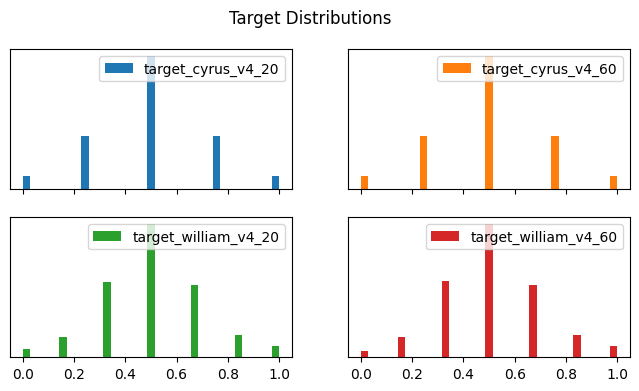

In [5]:
# Plot target distributions
targets_df[["target_cyrus_v4_20", "target_cyrus_v4_60", "target_william_v4_20", "target_william_v4_60"]].plot(kind="hist", bins=35, density=True, figsize=(8, 4), title="Target Distributions", subplots=True, layout=(2, 2), ylabel="", yticks=[]);

It is also important to note that the auxilary targets can be `NaN`, but the primary target will never be `NaN`. Since we are using tree-based models here we won't need to do any special pre-processing.

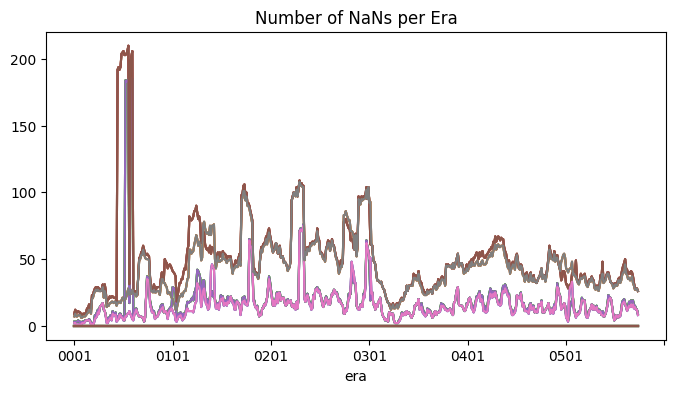

In [6]:
# print number of NaNs per era
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(8, 4), title="Number of NaNs per Era", legend=False);

The targets have a wide range of correlations with each other even though they are all fundamentally related, which should allow the construction of diverse models that ensemble together nicely.

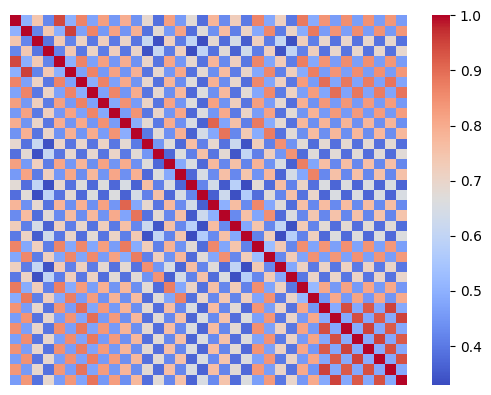

In [7]:
# Plot correlation matrix of targets
import seaborn as sns
sns.heatmap(targets_df[target_names].corr(), cmap="coolwarm", xticklabels=False, yticklabels=False);

Since we are ultimately trying to predict the main target (`target_cyrus_v4_20`), it is perhaps most important to consider each auxilliary target's correlation to it.

In [23]:
correlations_to_main_target = targets_df[target_names].corrwith(targets_df["target_cyrus_v4_20"]).sort_values(ascending=False).to_frame("corr_with_cyrus_v4_20")
correlations_to_main_target

,corr_with_cyrus_v4_20
target_cyrus_v4_20,1.000000
target_xerxes_v4_20,0.951769
target_caroline_v4_20,0.938431
target_sam_v4_20,0.923222
target_ralph_v4_20,0.897583
target_victor_v4_20,0.841422
target_nomi_v4_20,0.840183
target_william_v4_20,0.838008
target_waldo_v4_20,0.833459
target_thomas_v4_20,0.807668


## 2. Target Selection

Our goal is to create an ensemble of models trained on different targets. But which targets should we use?

To keep things simple and fast, let's just arbitrarily pick a few 20-day targets to evaluate.

In [9]:
# Arbitrarily pick 5 20-day target candidates
target_candidates = ["target_cyrus_v4_20", "target_victor_v4_20", "target_xerxes_v4_20", "target_jerome_v4_20"]

Like usual we will train on the training dataset.

In [10]:
import lightgbm as lgb

models = {}
for target in target_candidates:
    filename = f"small_lgb_{target}.model"
    try: 
        model = lgb.Booster(model_file=filename);
        print(f"loaded model for {target}")
    except lgb.basic.LightGBMError:
        print(f"training model for {target}")
        model = lgb.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=5,
            num_leaves=2 ** 5,
            colsample_bytree=0.1
        )
        model.fit(
            training_data[feature_cols],
            training_data[target]
        );
        model.booster_.save_model(filename);
    models[target] = model

loaded model for target_cyrus_v4_20
loaded model for target_victor_v4_20
loaded model for target_xerxes_v4_20
loaded model for target_jerome_v4_20


Then we will generate predictions on the validation dataset.

In [11]:
# Download validation data 
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + target_cols) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

2023-08-04 14:04:48,277 INFO numerapi.utils: target file already exists
2023-08-04 14:04:48,278 INFO numerapi.utils: download complete


In [12]:
# Generate validation predictions for each model
for target in target_candidates:
    try: 
        validation_data[f"prediction_{target}"] = pd.read_parquet(f"predictions_{target}.parquet")
        print(f"loaded predictions for {target}")
    except:
        print(f"generating predictions for {target}")
        validation_data[f"prediction_{target}"] = models[target].predict(validation_data[feature_cols])
        validation_data[f"prediction_{target}"].to_frame().to_parquet(f"predictions_{target}.parquet")

pred_cols = [f"prediction_{target}" for target in target_candidates]
validation_data[pred_cols]

loaded predictions for target_cyrus_v4_20
loaded predictions for target_victor_v4_20
loaded predictions for target_xerxes_v4_20
loaded predictions for target_jerome_v4_20


,prediction_target_cyrus_v4_20,prediction_target_victor_v4_20,prediction_target_xerxes_v4_20,prediction_target_jerome_v4_20
id,,,,
n000101811a8a843,0.488841,0.487900,0.488633,0.491561
n001e1318d5072ac,0.495411,0.497427,0.495531,0.495713
n002a9c5ab785cbb,0.502395,0.507322,0.502250,0.504641
n002ccf6d0e8c5ad,0.507658,0.508063,0.507810,0.505744
n0051ab821295c29,0.486678,0.488919,0.487671,0.472032
...,...,...,...,...
nffd992c1cbbee9d,0.498186,0.498313,0.498969,0.497639
nffda26c01c40824,0.502603,0.507170,0.502831,0.510654
nffe3c2374ae1a08,0.483843,0.488330,0.484555,0.482443


In [13]:
from scipy import stats
import numpy as np

def numerai_corr(preds, target):
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    centered_target = target - target.mean()
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    return np.corrcoef(preds_p15, target_p15)[0, 1]

As you can see in the performance chart below, models trained on the auxiliary target are able to predict the main target pretty well, but the model trained on the main target performns the best. 

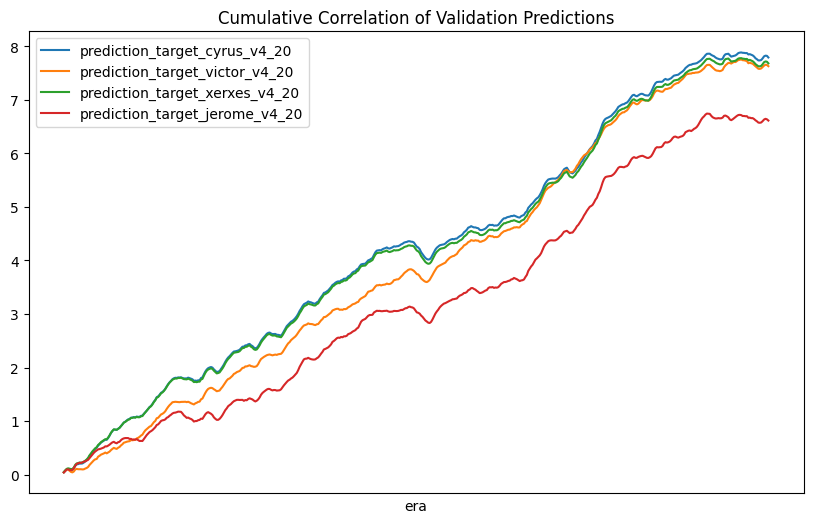

In [14]:
correlations = {}
cumulative_correlations = {}
for target in target_candidates:
    correlations[f"prediction_{target}"] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[f"prediction_{target}"], d["target"]))
    cumulative_correlations[f"prediction_{target}"] = correlations[f"prediction_{target}"].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of Validation Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary metrics below, we can make a few more observations
- the model trained on `jerome` has the worst performance (lower mean, lower sharpe), so maybe it isn't the best candidate for our simple ensemble.
- the model trained on `xerxes` has good performance (similar lower mean, sharpe, max drawdown as `cyrus`), but it is so correlated (94%) with `cyrus` that we may not see much gains from ensembling.
- the model trained on `victor` has great performance (slightly lower mean, better sharpe and max drawdown) and is not very correlated (83%) with `cyrus`, which makes it a good candidate for ensembling.   

In [15]:
summary_metrics = {}
for target in target_candidates:
    # per era correlation between this target and cyrus 
    mean_corr_with_cryus = validation_data.groupby("era").apply(lambda d: d[target].corr(d["target_cyrus_v4_20"])).mean()
    mean = correlations[f"prediction_{target}"].mean()
    std = correlations[f"prediction_{target}"].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[f"prediction_{target}"].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[f"prediction_{target}"]).max()
    summary_metrics[f"prediction_{target}"] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
        "mean_corr_with_cryus": mean_corr_with_cryus,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics).T
summary

,mean,std,sharpe,max_drawdown,mean_corr_with_cryus
prediction_target_cyrus_v4_20,0.015776,0.021437,0.735907,0.342537,1.000000
prediction_target_victor_v4_20,0.015446,0.018895,0.817447,0.239126,0.828178
prediction_target_xerxes_v4_20,0.015553,0.021620,0.719396,0.343580,0.941121
prediction_target_jerome_v4_20,0.013390,0.021285,0.629091,0.307319,0.773912


Based on our simple analysis above, it seems like target `victor` is the best candidate target for our ensemble since it has great performance and it is not too correlated with cyrus. What do you think?

Note that this target selection heuristic is extremely basic. In your own research, you will most likely want to consider all targets instead of just our favorites, and may want to experiment with different ways of selecting your ensemble targets.

## 3. Ensembling

Now that we have picked our candidate target for the ensemble, let's ensemble our predictions and re-evaluate performance.

For simplicity, we will equal weight the predictions from target victor and cyrus. Note that this is an extremely basic and arbitrary way of selecting ensemble weights. In your research, you may want to experiment with different ways of setting ensemble weights.

Tip: remember to always normalize (percentile rank) your predictions before averaging so that they are comparable!

In [16]:
# Ensemble predictions together with a simple average
favorite_targets = ["target_cyrus_v4_20", "target_victor_v4_20"]
ensemble_cols = [f"prediction_{target}" for target in favorite_targets]
validation_data["ensemble"] = validation_data.groupby("era")[ensemble_cols].rank(pct=True).mean(axis=1)

# Print the ensemble predictions
pred_cols = ensemble_cols + ["ensemble"]
validation_data[pred_cols]

,prediction_target_cyrus_v4_20,prediction_target_victor_v4_20,ensemble
id,,,
n000101811a8a843,0.488841,0.487900,0.049865
n001e1318d5072ac,0.495411,0.497427,0.301895
n002a9c5ab785cbb,0.502395,0.507322,0.735894
n002ccf6d0e8c5ad,0.507658,0.508063,0.858005
n0051ab821295c29,0.486678,0.488919,0.044035
...,...,...,...
nffd992c1cbbee9d,0.498186,0.498313,0.409146
nffda26c01c40824,0.502603,0.507170,0.734162
nffe3c2374ae1a08,0.483843,0.488330,0.036871


Looking at the performance chart below, we can see that the peformance of our ensemble is better than that of each individual model.

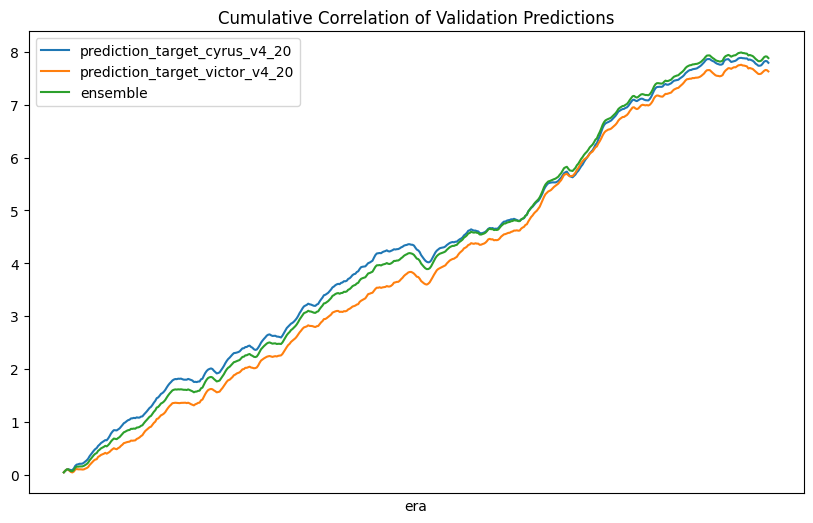

In [17]:
correlations = {}
cumulative_correlations = {}
for col in pred_cols:
    correlations[col] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of Validation Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary metrics below, we can see that our ensemble seems to have better `mean`, `sharpe`, and `max_drawdown` than the default cyrus model which is great! 

In [18]:
summary_metrics = {}
for col in pred_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics).T
summary

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,0.015776,0.021437,0.735907,0.342537
prediction_target_victor_v4_20,0.015446,0.018895,0.817447,0.239126
ensemble,0.015957,0.020396,0.782343,0.302971


Based on these results, it seems like ensembling models trained on auxiliary targets can potentially help with all aspects of performance. Given how many targets and how uncorrelated they are with each other, this should be a fruitful avenue of research.

However, it is also important to note that whether or not to create an ensemble is completely up to you. In fact, there are many great performing models that don't make use of the auxilliary targets at all.

If you are interested in learning more about targets, we highly encourage you to read up on these forum posts
- https://forum.numer.ai/t/how-to-ensemble-models/4034
- https://forum.numer.ai/t/target-jerome-is-dominating-and-thats-weird/6513

## Model Upload
To wrap up this notebook, let's pickle and upload our ensemble.

As usual, we will be wrapping our submission pipeline into a function. Since we already have our favorite targets and trained models in memory, we can simply reference them in our function.  

In [19]:
def predict_ensemble(live_features: pd.DataFrame) -> pd.DataFrame:
    # generate predictions from each model
    predictions = pd.DataFrame(index=live_features.index)
    for target in favorite_targets:
        predictions[target] = models[target].predict(live_features[feature_cols])
    # ensemble predictions
    ensemble = predictions.rank(pct=True).mean(axis=1)
    # format submission
    submission = ensemble.rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [20]:
# Quick test
current_round_number = napi.get_current_round()
napi.download_dataset("v4.1/live.parquet", f"v4.1/live_{current_round_number}.parquet")
live_features = pd.read_parquet(f"v4.1/live_{current_round_number}.parquet", columns=feature_cols)
predict_ensemble(live_features)

2023-08-04 14:05:21,114 INFO numerapi.utils: target file already exists
2023-08-04 14:05:21,115 INFO numerapi.utils: download complete


,prediction
id,
n0013e7ad9840068,0.012553
n003ddfd397905b8,0.479652
n0067c1a65e07b8c,0.830330
n0082fb8bdca1d26,0.718364
n008aa85c29bc43c,0.338125
...,...
nffa8bf49d14a3b0,0.440373
nffbc619347f6953,0.114193
nffcccc888fe966b,0.226159


In [21]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_ensemble)
with open("predict_ensemble.pkl", "wb") as f:
    f.write(p)

In [22]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_ensemble.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model!